# 1-import Data


In [1]:
import pandas as pd

    ### -use concat to add the new data from other months in the future


In [2]:
taxi_jan_2019 = pd.read_parquet('yellow_tripdata_2019-01.parquet')
taxi_db = pd.concat([taxi_jan_2019])

In [3]:
taxi_db.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


Take a look

In [4]:
taxi_db.shape

(7696617, 19)

# 2-Data exporation

In [5]:
taxi_db.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
taxi_db = taxi_db[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID','PULocationID',
        'DOLocationID', 'payment_type', 'total_amount']]

In [7]:
taxi_db.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55


In [8]:
taxi_db.shape

(7696617, 9)

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

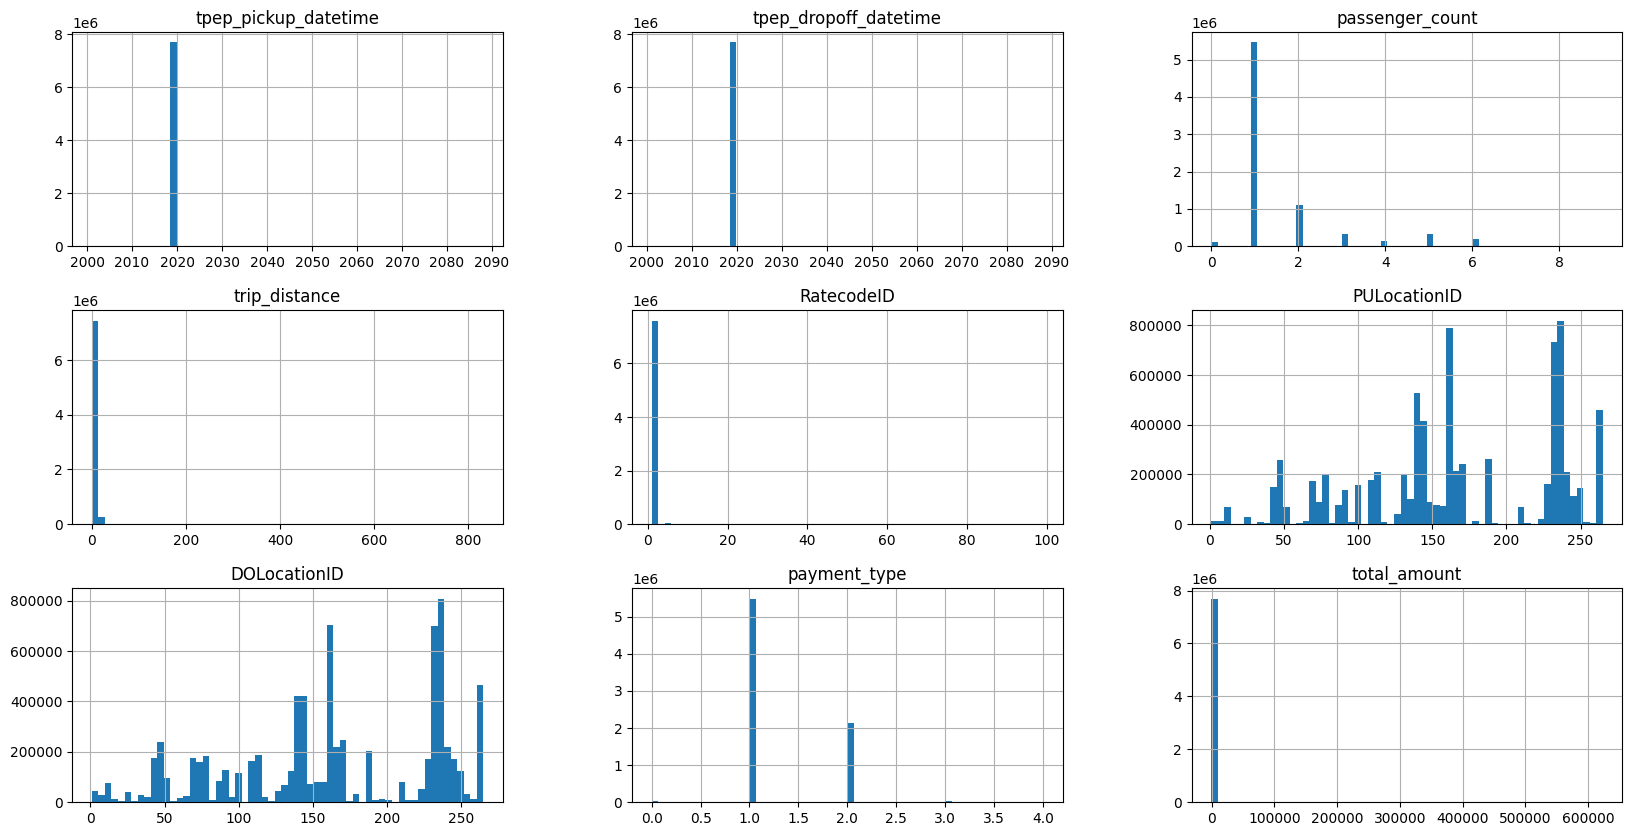

In [9]:
taxi_db.hist(figsize=(20,10), bins=60)

In [10]:
taxi_db['RatecodeID'].value_counts()


,count
RatecodeID,
1.0,7430288
2.0,166093
5.0,54570
3.0,11801
4.0,4895
99.0,252
6.0,46


<Axes: xlabel='index', ylabel='total_amount'>

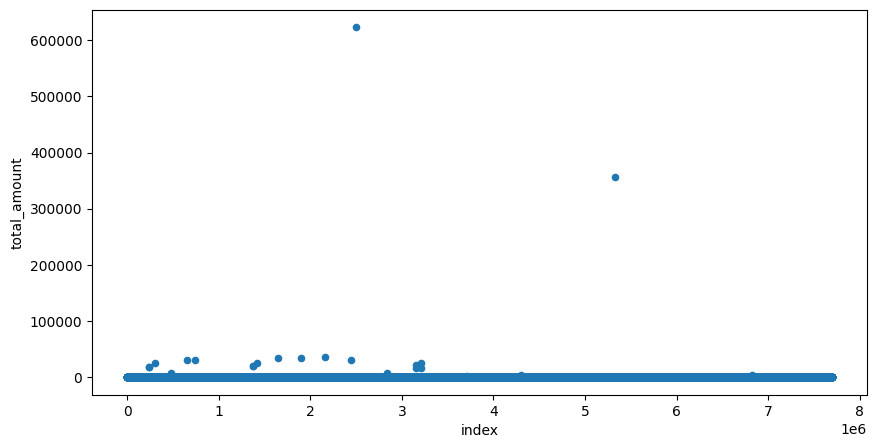

In [11]:
taxi_db.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

<Axes: xlabel='index', ylabel='total_amount'>

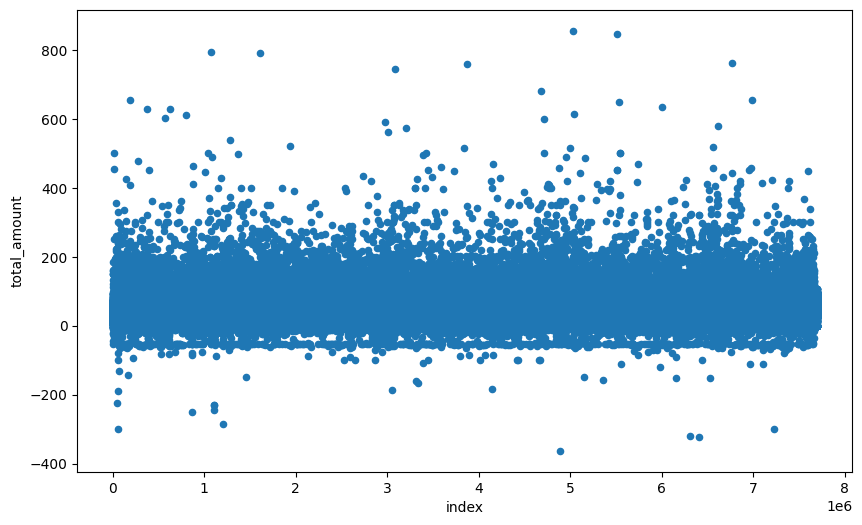

In [12]:
taxi_db[taxi_db['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,6))

(7127, 9)


<Axes: xlabel='index', ylabel='total_amount'>

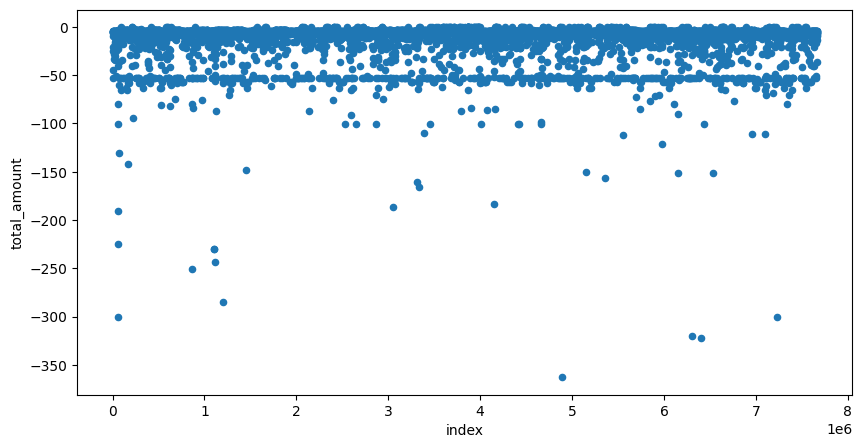

In [13]:
print(taxi_db[taxi_db['total_amount']<0].shape)
taxi_db[taxi_db['total_amount']<0].reset_index().plot(figsize=(10,5) ,kind='scatter', y='total_amount', x='index')

In [14]:
taxi_db[taxi_db['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2.0,0.10,1.0,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1.0,4.13,1.0,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1.0,1.35,1.0,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1.0,0.00,1.0,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1.0,0.16,1.0,234,234,4,-4.3


In [15]:
taxi_db[taxi_db['total_amount']<0]['payment_type'].value_counts()

,count
payment_type,
3,4083
4,2667
2,376
1,1


In [16]:
taxi_db[taxi_db['total_amount']==0].shape
taxi_db[taxi_db['total_amount']==0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1.0,0.0,5.0,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1.0,0.0,5.0,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1.0,0.0,1.0,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1.0,0.0,1.0,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1.0,0.0,1.0,264,7,2,0.0


In [17]:
taxi_db_prepared = taxi_db.copy()

In [18]:
taxi_db_prepared = taxi_db_prepared[(taxi_db_prepared['total_amount']>=0)&(taxi_db_prepared['total_amount']<2000)]
taxi_db_prepared.dtypes

,0
tpep_pickup_datetime,datetime64[us]
tpep_dropoff_datetime,datetime64[us]
passenger_count,float64
trip_distance,float64
RatecodeID,float64
PULocationID,int64
DOLocationID,int64
payment_type,int64
total_amount,float64


In [19]:
taxi_db_prepared['transiction_date'] = pd.to_datetime(taxi_db_prepared['tpep_pickup_datetime'].dt.date)
taxi_db_prepared['transiction_year'] = taxi_db_prepared['tpep_pickup_datetime'].dt.year
taxi_db_prepared['transiction_month'] = taxi_db_prepared['tpep_pickup_datetime'].dt.month
taxi_db_prepared['transiction_day'] = taxi_db_prepared['tpep_pickup_datetime'].dt.day
taxi_db_prepared['transiction_hour'] = taxi_db_prepared['tpep_pickup_datetime'].dt.hour

In [20]:
taxi_db_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transiction_date,transiction_year,transiction_month,transiction_day,transiction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55,2018-11-28,2018,11,28,15


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>,
        <Axes: title={'center': 'trip_distance'}>],
       [<Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>,
        <Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>],
       [<Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'transiction_date'}>,
        <Axes: title={'center': 'transiction_year'}>,
        <Axes: title={'center': 'transiction_month'}>],
       [<Axes: title={'center': 'transiction_day'}>,
        <Axes: title={'center': 'transiction_hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

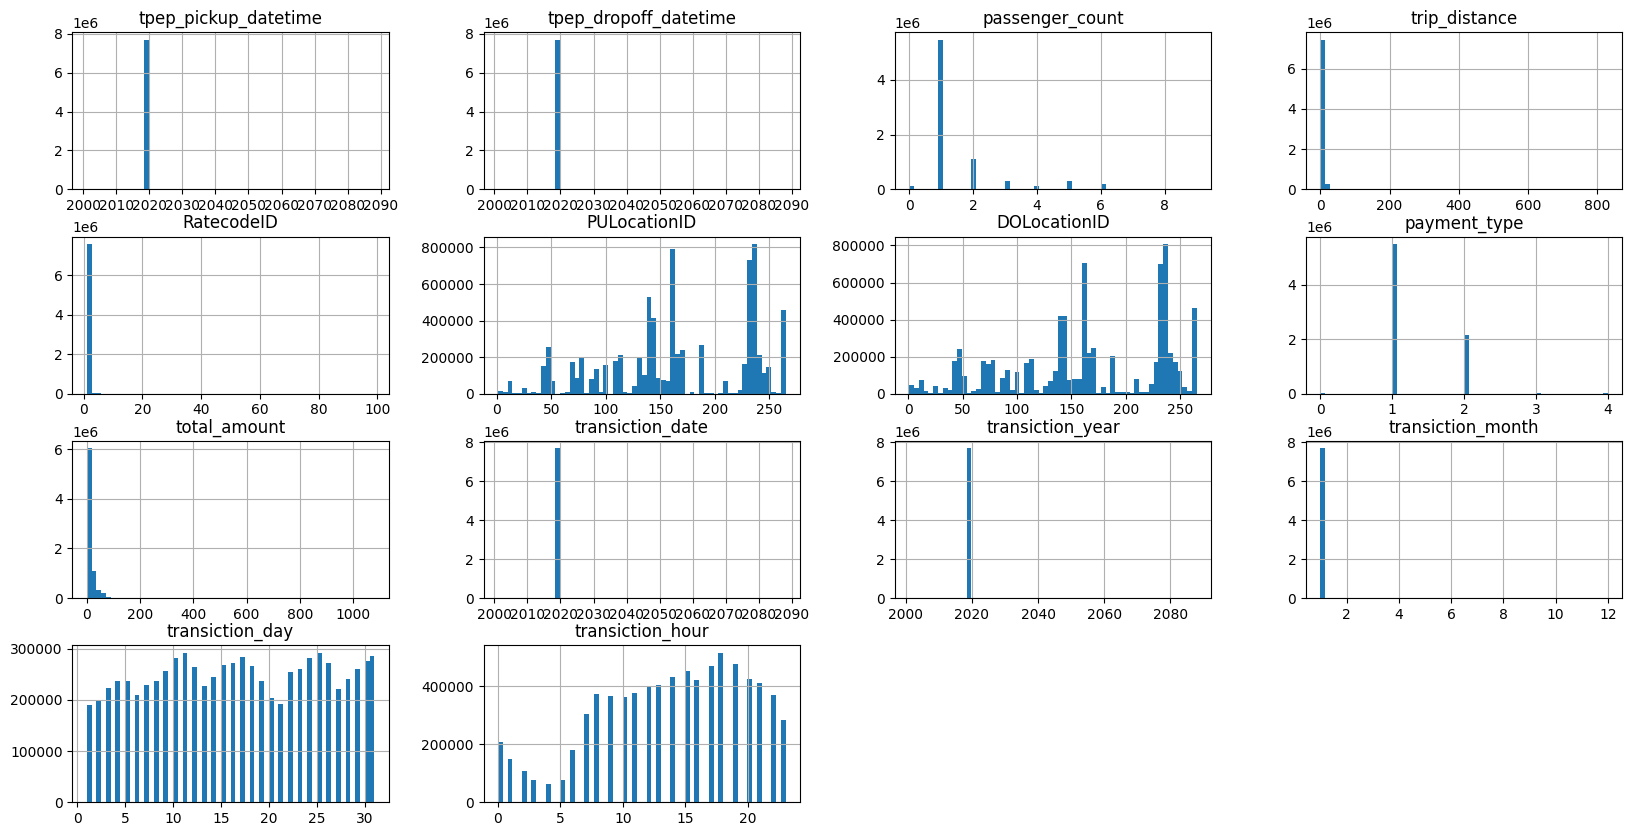

In [21]:
taxi_db_prepared.hist(figsize=(20,10), bins = 60)

In [22]:
taxi_db_prepared = taxi_db_prepared[taxi_db_prepared['transiction_year'] == 2019]
taxi_db_prepared = taxi_db_prepared[taxi_db_prepared['transiction_month'] == 1]

In [23]:
taxi_db_prepared.head()


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transiction_date,transiction_year,transiction_month,transiction_day,transiction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30,2019-01-01,2019,1,1,0
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,1.0,163,229,1,9.05,2019-01-01,2019,1,1,0
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,1.0,229,7,1,18.50,2019-01-01,2019,1,1,0
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.1,1.0,141,234,1,13.00,2019-01-01,2019,1,1,0


In [24]:
categioral_columns = ['PULocationID', 'transiction_date','transiction_month','transiction_day','transiction_hour']
numerical_columns = ['trip_distance','total_amount']
all_needed_columns = categioral_columns + numerical_columns



In [25]:
main_taxi_db = taxi_db_prepared[all_needed_columns]
print(main_taxi_db.shape)
main_taxi_db.head()

(7688931, 7)


,PULocationID,transiction_date,transiction_month,transiction_day,transiction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05
8,229,2019-01-01,1,1,0,3.7,18.50
9,141,2019-01-01,1,1,0,2.1,13.00


In [26]:
taxi_grouped_by_region = main_taxi_db.groupby(categioral_columns).mean().reset_index()
taxi_grouped_by_region['transiction_count'] = main_taxi_db.groupby(categioral_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(102779, 8)


,PULocationID,transiction_date,transiction_month,transiction_day,transiction_hour,trip_distance,total_amount,transiction_count
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


<Axes: >

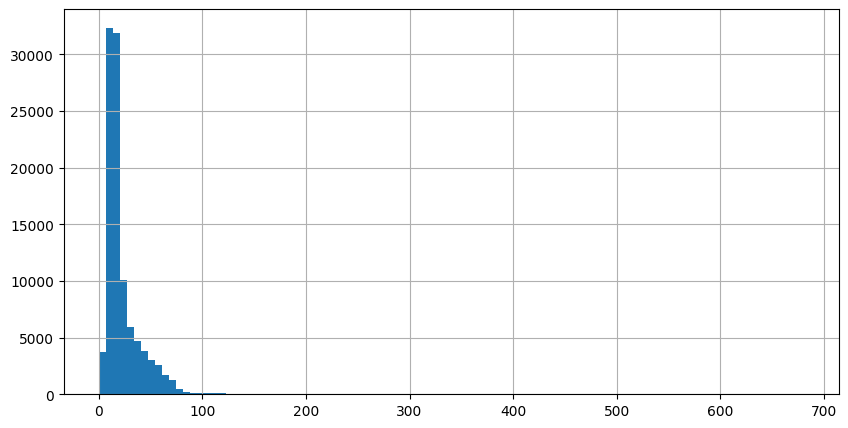

In [27]:
taxi_grouped_by_region['total_amount'].hist(bins=100, figsize=(10,5))


<Axes: >

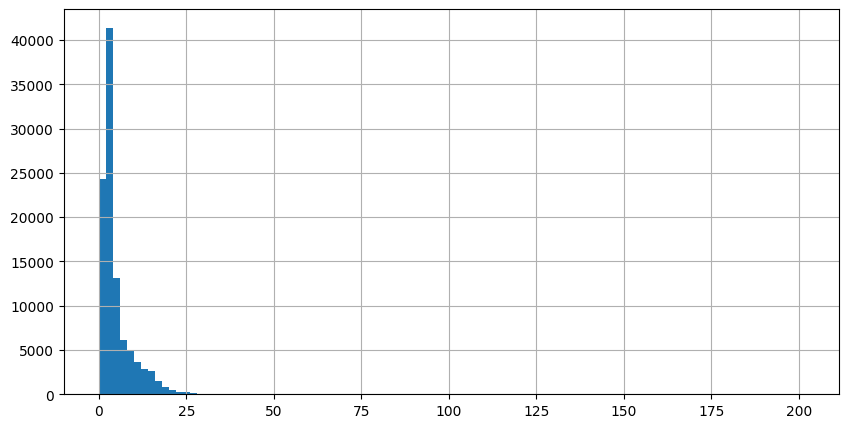

In [28]:
taxi_grouped_by_region['trip_distance'].hist(bins=100, figsize=(10,5))

In [29]:
data_benchmark_model = taxi_grouped_by_region.copy()
data_benchmark_model

,PULocationID,transiction_date,transiction_month,transiction_day,transiction_hour,trip_distance,total_amount,transiction_count
0,1,2019-01-01,1,1,2,0.000000,21.800000,1
1,1,2019-01-01,1,1,5,0.000000,87.300000,1
2,1,2019-01-01,1,1,6,0.000000,80.300000,1
3,1,2019-01-01,1,1,8,0.000000,128.580000,2
4,1,2019-01-01,1,1,10,16.900000,43.245000,4
...,...,...,...,...,...,...,...,...
102774,265,2019-01-31,1,31,19,9.205909,49.779545,22
102775,265,2019-01-31,1,31,20,0.117500,69.225000,4
102776,265,2019-01-31,1,31,21,1.446667,85.703333,6
102777,265,2019-01-31,1,31,22,1.006667,71.665000,12


In [30]:
categioral_features_benchmark = ['PULocationID','transiction_month','transiction_day','transiction_hour']
input_features_benchmark = categioral_features_benchmark + ['trip_distance']
target_features_benchmark = ['total_amount']

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
x_bench = data_benchmark_model[input_features_benchmark]
y_bench = data_benchmark_model[target_features_benchmark]

x_bench = pd.get_dummies(x_bench)

x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(x_bench,y_bench, test_size= 0.33, random_state=42)

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(x_train_b,y_train_b)

DecisionTreeRegressor(max_depth=10)

In [34]:
model_at_hand = tree

y_pred_b = model_at_hand.predict(x_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error',mean_absolute_error(y_test_b,y_pred_b))
print('mean_squared_error',mean_squared_error(y_test_b,y_pred_b))
print('sqrt',sqrt(mean_squared_error(y_test_b,y_pred_b)))
print('r2_score',r2_score(y_test_b, y_pred_b))

mean_absolute_error 3.8402387814356596
mean_squared_error 135.10870412220459
sqrt 11.623626977936128
r2_score 0.6425953672618385
